In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Dense, GlobalAveragePooling2D, Flatten,
                                     BatchNormalization, Dropout, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:

# === Vision Transformer (Custom Implementation) ===
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = tf.keras.layers.Dense(projection_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return self.projection(patches)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='gelu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class VisionTransformer(tf.keras.layers.Layer):
    def __init__(self, input_shape=(224, 224, 3), patch_size=16, embed_dim=128, num_heads=4, ff_dim=256, num_layers=6):
        super().__init__()
        self.num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
        self.embed = PatchEmbedding(patch_size, embed_dim)
        self.cls_token = self.add_weight(name="cls_token", shape=(1, 1, embed_dim), initializer="zeros", trainable=True)
        self.pos_emb = self.add_weight(name="pos_emb", shape=(1, self.num_patches + 1, embed_dim), initializer="random_normal", trainable=True)
        self.blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]
        x = self.embed(x)
        cls_token = tf.tile(self.cls_token, [batch_size, 1, 1])
        x = tf.concat([cls_token, x], axis=1)
        x += self.pos_emb
        for blk in self.blocks:
            x = blk(x, training=training)
        return self.flatten(x[:, 0])




In [5]:

# === Data Loading ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_DIR = os.path.expanduser("~/Desktop/Dataset xray/Dataset labelled")

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 7395 images belonging to 2 classes.
Found 1848 images belonging to 2 classes.


In [6]:
# === Input Layer ===
input_layer = Input(shape=(224, 224, 3), name="input_image")

In [7]:
# === DenseNet169 ===
dn_base = DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
dn_base.trainable = False
dn_feat = Flatten()(GlobalAveragePooling2D()(dn_base(input_layer)))


In [8]:
# === MobileNetV2 ===
mob_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mob_base.trainable = False
mob_feat = Flatten()(GlobalAveragePooling2D()(mob_base(input_layer)))


In [9]:
# === Vision Transformer (Custom) ===
vit_feat = VisionTransformer()(input_layer)

In [10]:

# === Concatenate and Classifier Head ===
concat = Concatenate()([dn_feat, mob_feat, vit_feat])

x = Dense(512, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ input_image[0][0] │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_image[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_transformer  │ (None, 128)       │  2,105,216 │ input_image[0][0] │
│ (VisionTransformer) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3072)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ vision_transform… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │  1,573,376 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     16,448 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 2)         │        130 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 18,730,690 (71.45 MB)

 Trainable params: 3,828,162 (14.60 MB)

 Non-trainable params: 14,902,528 (56.85 MB)

In [11]:
# === Compile and Train ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)


c:\Users\DRISHTI\Desktop\Major project nemo\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7690 - loss: 0.5531 - val_accuracy: 0.8588 - val_loss: 0.3151
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.8573 - loss: 0.3349 - val_accuracy: 0.8653 - val_loss: 0.2886
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.8738 - loss: 0.3052 - val_accuracy: 0.8777 - val_loss: 0.2741
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.8786 - loss: 0.2785 - val_accuracy: 0.8788 - val_loss: 0.2662
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8871 - loss: 0.2630 - val_accuracy: 0.8847 - val_loss: 0.2619
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.8948 - loss: 0.2427 - val_accuracy: 0.8777 - val_loss: 0.2633
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9016 - loss: 0.2323 - val_accuracy: 0.8847 - val_loss: 0.2538
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9043 - loss: 0.2168 - val_accu

In [12]:
# === Test Evaluation & Visualization ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9243 images belonging to 2 classes.


In [14]:
# Predictions
import numpy as np
pred_probs = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())


289/289 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step


In [16]:
# Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93      4048
   Pneumonia       0.97      0.92      0.95      5195

    accuracy                           0.94      9243
   macro avg       0.94      0.94      0.94      9243
weighted avg       0.94      0.94      0.94      9243



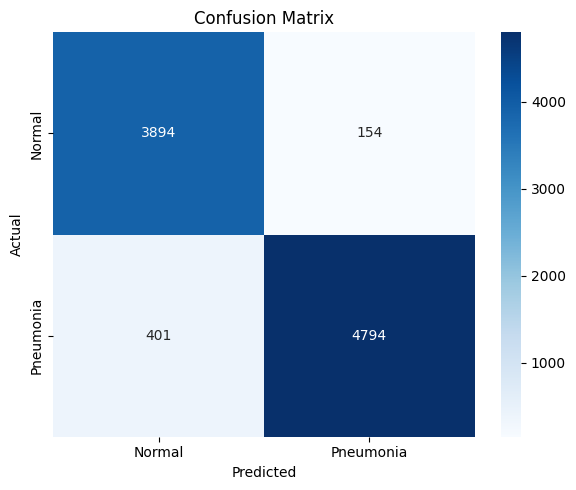

In [20]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

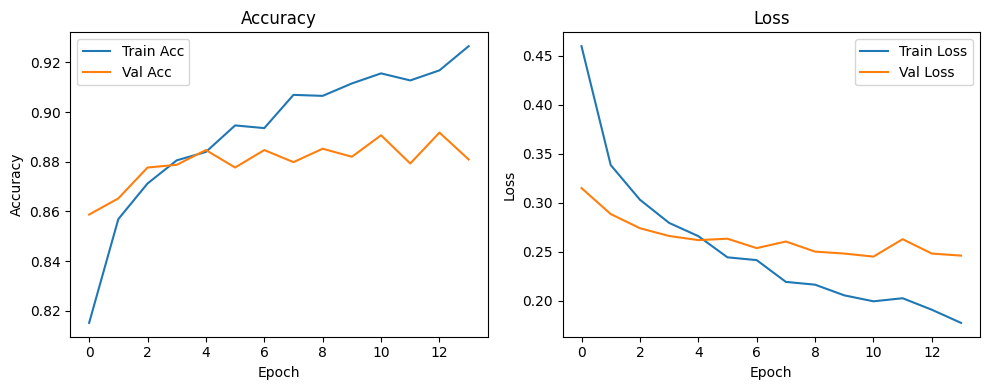

In [21]:
# Training History Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
